# Projeto

Um trabalho desenvolvido na disciplina de Machine Learning (Estatística-UFSM) para aplicar as técnicas de ML visando predizer o vencedor da Copa do Mundo FIFA 2022, simulando partida a partida da fase de grupo até a grande final.

Utilizando dois datasets como fontes [International football results from 1872 to 2022](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) e [FIFA World Ranking 1992-2022](https://www.kaggle.com/datasets/cashncarry/fifaworldranking).

A estruturação do feature engineering presente nesse trabalho foi desenvolvida em [Soccer World Cup 2018 Winner](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). No entanto, foi realizado uma metodologia buscando uma acurácia melhor, adicionando pouca complexidade (covariáveis) ao modelo. 

Os modelos utilizados são para classificação binária para simplificação da modelagem e estruturação das variáveis, assim os modelos são para predizer vitória/derrota, com as partidas que foram empates sendo excluídas da modelagem. A probabilidade de vencer a partida é dada como a média de vencer a partida dentro de casa e fora de casa (pois na copa do mundo não tem vantagem de mandante).

O autor da modelagem para a previsão do vencedor da Copa do Mundo de 2018, que utilizei como base desse projeto, também realizou a modelagem para a Copa de 2022, estando disponível em [Predicting FIFA 2022 World Cup with ML](https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml).

In [1]:
import numpy as np 
import pandas as pd
import re 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Modelagem 

Após a construção das variáveis e sua avaliação, nós temos os dataset prontos com colunas com poder preditivo interessante (como visto em feature_analysis), nós podemos começar a modelagem.

Nós iremos testar 3 modelos: Regressão Logística, Random Forest e Gradient Boosting. Selecionaremos o modelo com melhor Recall/Revocação/Sensibilidade.

In [2]:
model_db = pd.read_csv('data/modelling_dataset.csv')
team_stats_raw = pd.read_csv('data/team_stats_by_match.csv')

In [3]:
X = model_db.iloc[:, 3:]
y = model_db[["result"]]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [5]:
np.linspace(0.1, 15, 25)

array([ 0.1       ,  0.72083333,  1.34166667,  1.9625    ,  2.58333333,
        3.20416667,  3.825     ,  4.44583333,  5.06666667,  5.6875    ,
        6.30833333,  6.92916667,  7.55      ,  8.17083333,  8.79166667,
        9.4125    , 10.03333333, 10.65416667, 11.275     , 11.89583333,
       12.51666667, 13.1375    , 13.75833333, 14.37916667, 15.        ])

In [6]:
gb = GradientBoostingClassifier(random_state=15)

params = {
            "learning_rate": [0.03, 0.04],
            "min_samples_split": [3],
            "min_samples_leaf": [5],
            "max_depth":[5],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1, verbose = False)

In [7]:
gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=15),
             n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.04], 'max_depth': [5],
                         'max_features': ['sqrt'], 'min_samples_leaf': [5],
                         'min_samples_split': [3], 'n_estimators': [100, 200]},
             verbose=False)

In [8]:
gb = gb_cv.best_estimator_

In [9]:
print(gb_cv.best_params_)

{'learning_rate': 0.03, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 100}


In [10]:
params_rf = {
            "min_samples_split": [14, 15, 17],
            "min_samples_leaf": [5],
            "max_depth":[8],
            "max_features":["log2", "sqrt"],
            "max_leaf_nodes": [100],
            "criterion": ["entropy", "log_loss"],
            "n_estimators":[500]
         } 

rf = RandomForestClassifier(random_state=5)

rf_cv = GridSearchCV(rf, params_rf, cv = 5, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'log_loss'], 'max_depth': [8],
                         'max_features': ['log2', 'sqrt'],
                         'max_leaf_nodes': [100], 'min_samples_leaf': [5],
                         'min_samples_split': [14, 15, 17],
                         'n_estimators': [500]},
             verbose=False)

In [11]:
rf = rf_cv.best_estimator_

In [12]:
print(rf_cv.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 500}


In [13]:
np.arange(0.01,0.5,0.05)

array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46])

In [14]:
params_rlog = {"C": np.arange(0.01,0.5,0.05), "penalty":["l1","l2", "elasticnet", "none"], "max_iter" : [10000]}# l1 lasso l2 ridge
rlog = LogisticRegression()
logreg_cv = GridSearchCV(rlog, params_rlog, cv=5, n_jobs = -1, verbose = False)
logreg_cv.fit(X_train.values, np.ravel(y_train))

e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\linear_model\_logistic.py", lin

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46]),
                         'max_iter': [10000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             verbose=False)

In [15]:
rlog = logreg_cv.best_estimator_

In [16]:
print(logreg_cv.best_params_)

{'C': 0.31000000000000005, 'max_iter': 10000, 'penalty': 'l2'}


In [17]:
# # Predicting the Test set results
# y_pred = rf.predict(X_test)
# #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
# # reversefactor = dict(zip(range(3),definitions))
# # y_test = np.vectorize(reversefactor.get)(y_test)
# # y_pred = np.vectorize(reversefactor.get)(y_pred)
# # Making the Confusion Matrix
# pd.crosstab(np.ravel(y_test), y_pred)

In [18]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

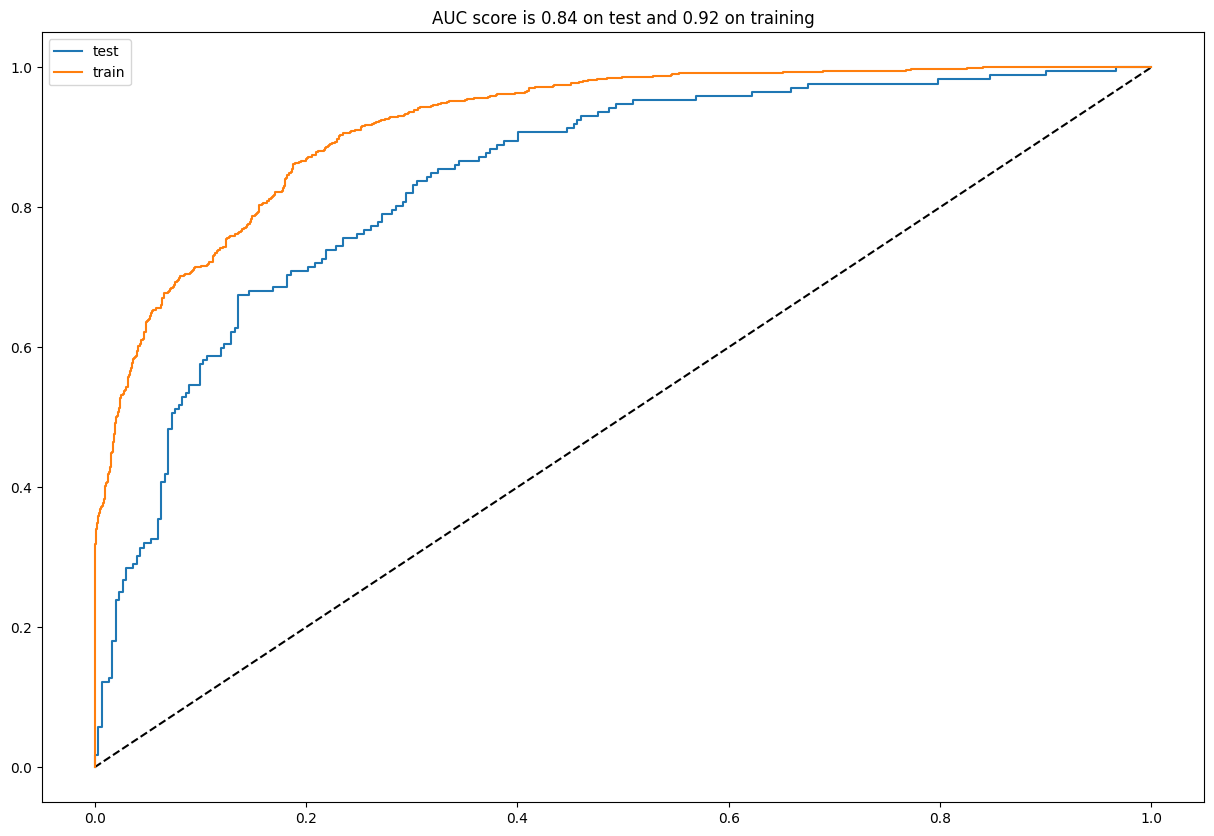

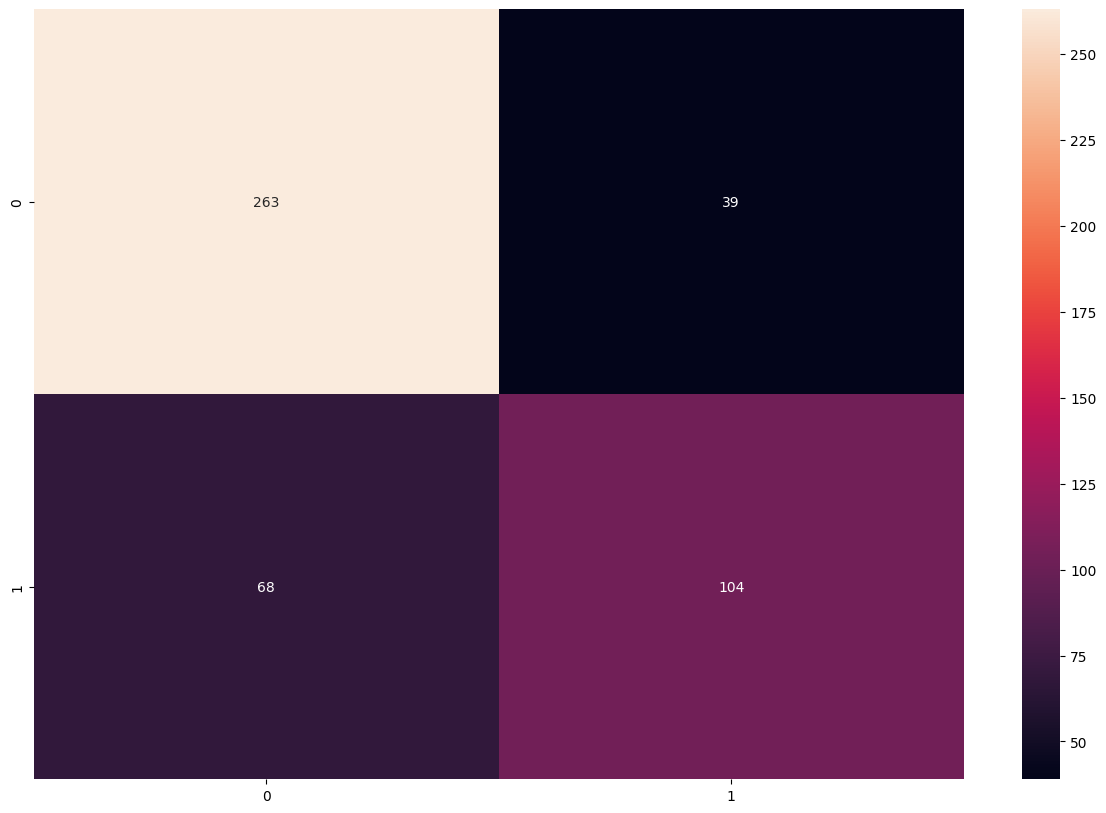

In [19]:
analyze(gb)

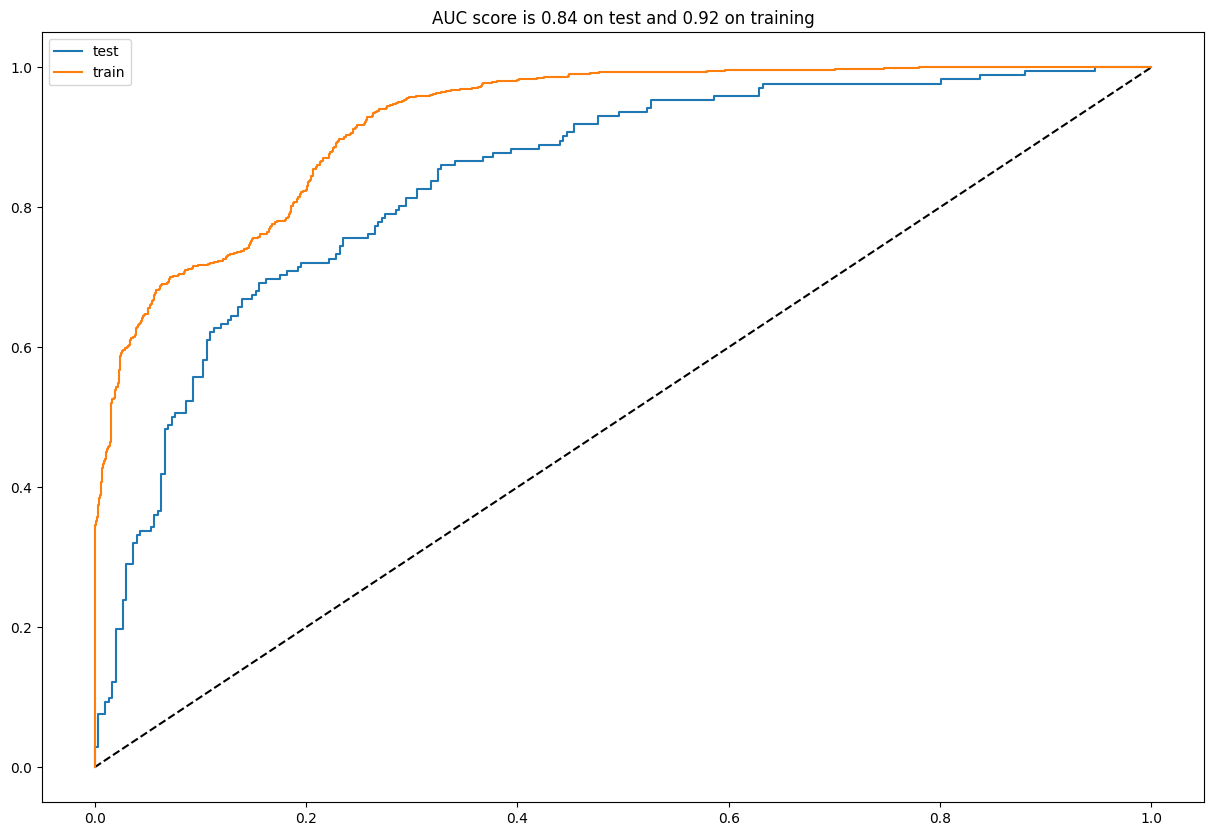

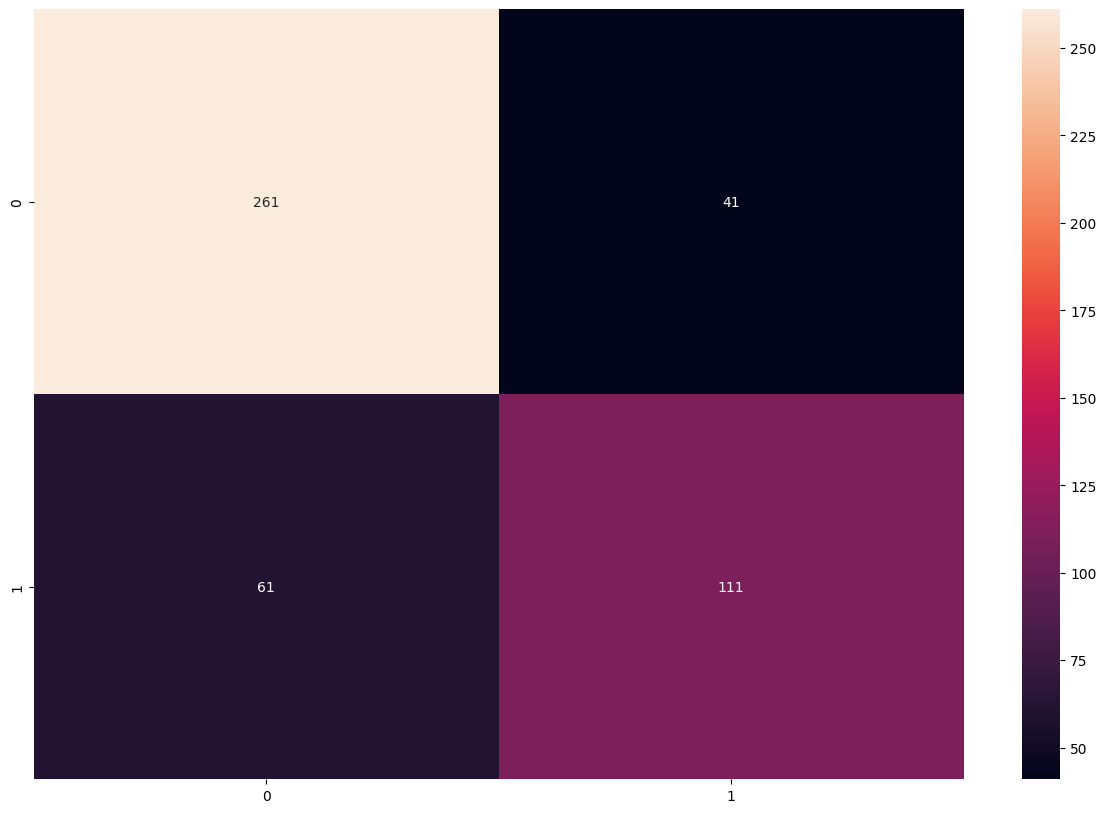

In [20]:
analyze(rf)

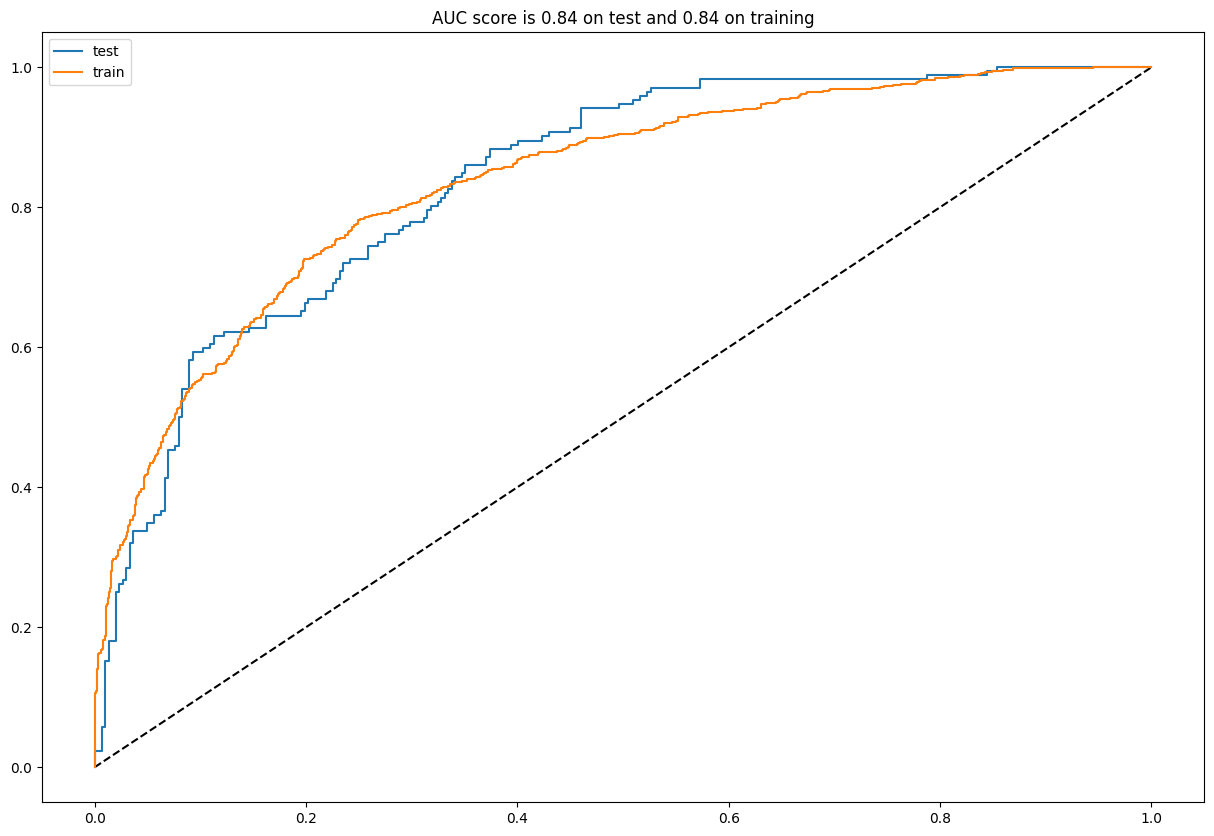

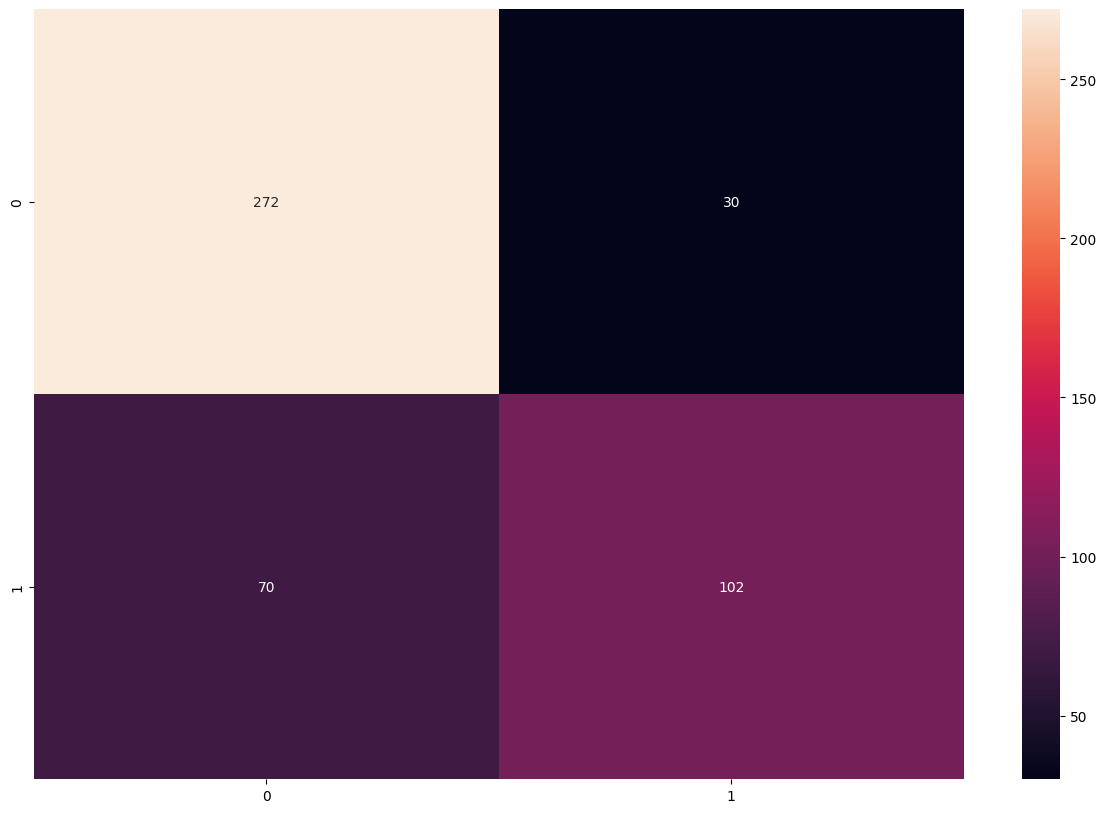

In [21]:
analyze(rlog)

O modelo que irei escolher para a "previsão oficial" será o modelo de Random Forest, pois os outros ficaram mais underfittados ou menos constantes em sementes diferentes. 

# Simulação da Copa

Para podermos simularmos os jogos, primeiramente vamos realizar um Web Scraping do Wikipédia para conseguirmos pegar os grupos, times e partidas da primeira fase. 

In [22]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [23]:
dfs[13]

,Pos,"Team.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:""[ ""}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:"" ]""}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}vte",Pld,W,D,L,GF,GA,GD,Pts,Qualification
0,1,Netherlands,1,1,0,0,2,0,+2,3[a],Advance to knockout stage
1,2,Ecuador,1,1,0,0,2,0,+2,3[a],Advance to knockout stage
2,3,Senegal,1,0,0,1,0,2,−2,0[b],NaN
3,4,Qatar (H),1,0,0,1,0,2,−2,0[b],NaN


In [24]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[13].iloc[:, 1].values)]

In [25]:
for i in range(14, 69, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

In [26]:
import copy

In [27]:
table_rf = copy.deepcopy(table)
table_rlog = copy.deepcopy(table)

Com a construção do grupo e os participante, é possível armazenar os pontos dos times e a probabilidade de ganhar cada jogo. 

Caso exista empate nos pontos, a probabilidade de vencer vai ser usada como desempate (na realidade, é a verdadeira métrica para avanço).

In [28]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

Para a construção das variáveis vamos utilizar a última partida do time para que possamos pegar os valores de cada covariável.


In [29]:
team_stats_raw

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.00,2,43.0,0.166667,1,6,1.00
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.00,2,-3.0,0.066667,1,2,0.50
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.00,0,-6.0,0.300000,3,1,1.50
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.00,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.00,0,13.0,0.375000,3,4,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3,4,0.75
6726,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1,6,0.25
6727,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0,8,0.00
6728,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0,6,0.00


In [30]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games['score'].mean()
    team_1_goals_l5 = last5['score'].mean()
    team_1_goals_suf = past_games['suf_score'].mean()
    team_1_goals_suf_l5 = last5['suf_score'].mean()
    team_1_rank_suf = past_games['rank_suf'].mean()
    team_1_rank_suf_l5 = last5['rank_suf'].mean()
    team_1_gp_rank = past_games['points_by_rank'].mean()
    team_1_gp_rank_l5 = last5['points_by_rank'].mean()
    team_1_points_by_classification = past_games['points_by_classification'].mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5, team_1_points_by_classification]

In [31]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    dif_points_by_classification = team_1[9] - team_2[9]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0, dif_points_by_classification]

Agora com as funções ``find_stats()`` e ``find_features()`` podemos começar a simulação.

No entanto, temos que definir algumas regras como os datasets estão divididos em mandante e visitante, assim como na copa do mundo são sempre campos neutros, iremos simular a mesma partida invertendo os mandantes. 

Assim o empate será definido quando mudar o resultado de acordo com o mando de campo.

In [32]:
X.columns

Index(['rank_dif', 'goals_dif', 'goals_dif_l5', 'goals_suf_dif',
       'goals_suf_dif_l5', 'goals_per_ranking_dif', 'dif_rank_agst',
       'dif_rank_agst_l5', 'dif_points_rank', 'dif_points_rank_l5',
       'is_friendly_0', 'is_friendly_1', 'dif_points_by_classification'],
      dtype='object')

In [33]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0] # Probabilidade de vitória do time 1 em casa
    team_1_prob_g2 = probs_g2[0][1] # Probabilidade de vitória do time 1 fora de casa
    team_2_prob_g1 = probs_g1[0][1] # Probabilidade de vitória do time 2 fora de casa
    team_2_prob_g2 = probs_g2[0][0] # Probabilidade de vitória do time 2 em casa

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Grupo %s classificados: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Começando a simulação para o Grupo %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Grupo %s - %s x %s: vencedor %s com %.2f probabilidade"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Grupo %s - %s x %s: Empate"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: Empate
Grupo A - Senegal x Netherlands: vencedor Netherlands com 0.62 probabilidade
Grupo A - Qatar x Senegal: vencedor Senegal com 0.71 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 0.75 probabilidade
Grupo A - Ecuador x Senegal: vencedor Senegal com 0.68 probabilidade
Grupo A - Netherlands x Qatar: Empate


Grupo A classificados: 
Netherlands -------- 7
Senegal -------- 6
Qatar -------- 2
Ecuador -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: vencedor England com 0.68 probabilidade
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: vencedor England com 0.59 probabilidade
Grupo B - Wales x England: vencedor England com 0.63 probabilidade
Grupo B - Iran x United States: Empate


Grupo B classificados: 
England -------- 9
United States -------- 2
Wales -------- 2
Iran --

The group phase predicted no surprises, or maybe the draw between Brazil and Switzerland or France and Denmark. For the playoffs phase, I'll predict and show it graphically as made [here](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). 

In [34]:
advanced = advanced_group

In [35]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Mexico'],
 ['France', 'Tunisia'],
 ['Spain', 'Germany'],
 ['Belgium', 'Morocco'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [36]:
playoffs = {"Oitavas de Final": [], "Quartas de Final": [], "Semi-Final": [], "Final": []}

In [37]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Oitavas de Final":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Começando a simulação de %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s x %s: %s avança com probabilidade %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s x %s: %s avança com probabilidade %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Começando a simulação de  %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s avança com probabilidade %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s avança com probabilidade %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Começando a simulação de Oitavas de Final
----------


Netherlands x United States: Netherlands avança com probabilidade 0.51
Argentina x Tunisia: Argentina avança com probabilidade 0.66
Spain x Morocco: Spain avança com probabilidade 0.62
Brazil x Uruguay: Brazil avança com probabilidade 0.64
Senegal x England: England avança com probabilidade 0.66
Mexico x France: France avança com probabilidade 0.52
Germany x Belgium: Belgium avança com probabilidade 0.58
Switzerland x Portugal: Portugal avança com probabilidade 0.52
----------
Começando a simulação de  Quartas de Final
----------


Netherlands vs. Argentina: Argentina avança com probabilidade 0.56
Spain vs. Brazil: Brazil avança com probabilidade 0.58
England vs. France: France avança com probabilidade 0.53
Belgium vs. Portugal: Belgium avança com probabilidade 0.59
----------
Começando a simulação de  Semi-Final
----------


Argentina vs. Brazil: Brazil avança com probabilidade 0.55
France vs. Belgium: France avança com

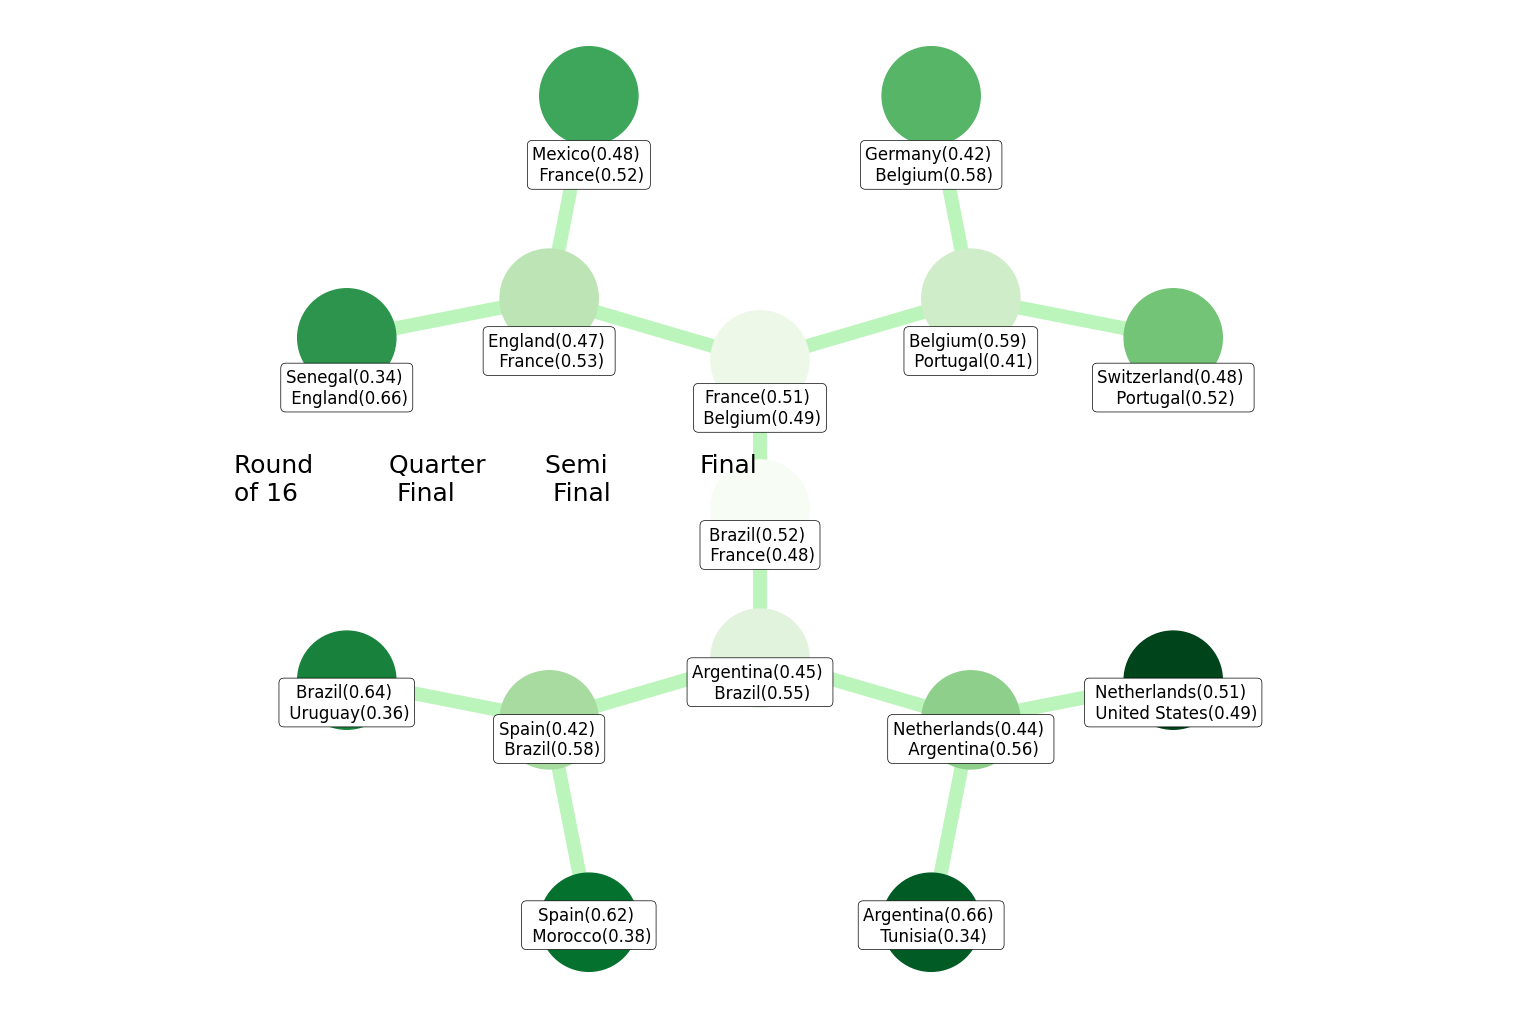

In [38]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

## Random forest

In [39]:
table = table_rf

In [40]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = rf.predict_proba([features_g1])
    probs_g2 = rf.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0] # Probabilidade de vitória do time 1 em casa
    team_1_prob_g2 = probs_g2[0][1] # Probabilidade de vitória do time 1 fora de casa
    team_2_prob_g1 = probs_g1[0][1] # Probabilidade de vitória do time 2 fora de casa
    team_2_prob_g2 = probs_g2[0][0] # Probabilidade de vitória do time 2 em casa

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Grupo %s classificados: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Começando a simulação para o Grupo %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Grupo %s - %s x %s: vencedor %s com %.2f probabilidade"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Grupo %s - %s x %s: Empate"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: Empate
Grupo A - Senegal x Netherlands: vencedor Netherlands com 0.63 probabilidade
Grupo A - Qatar x Senegal: vencedor Senegal com 0.72 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 0.72 probabilidade
Grupo A - Ecuador x Senegal: vencedor Senegal com 0.68 probabilidade
Grupo A - Netherlands x Qatar: vencedor Netherlands com 0.68 probabilidade


Grupo A classificados: 
Netherlands -------- 9
Senegal -------- 6
Ecuador -------- 1
Qatar -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: vencedor England com 0.69 probabilidade
Grupo B - United States x Wales: vencedor United States com 0.55 probabilidade
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: vencedor England com 0.62 probabilidade
Grupo B - Wales x England: vencedor England com 0.63 probabilidade
Grupo B - Iran x United States: vencedor United States co

In [41]:
advanced = advanced_group

In [42]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Spain', 'Germany'],
 ['Belgium', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [43]:
playoffs = {"Oitavas de Final": [], "Quartas de Final": [], "Semi-Final": [], "Final": []}

In [44]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Oitavas de Final":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rf.predict_proba([features_g1])
            probs_g2 = rf.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Começando a simulação de %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s x %s: %s avança com probabilidade %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s x %s: %s avança com probabilidade %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rf.predict_proba([features_g1])
            probs_g2 = rf.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Começando a simulação de  %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s avança com probabilidade %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s avança com probabilidade %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Começando a simulação de Oitavas de Final
----------


Netherlands x United States: Netherlands avança com probabilidade 0.55
Argentina x Denmark: Argentina avança com probabilidade 0.61
Spain x Croatia: Spain avança com probabilidade 0.60
Brazil x Uruguay: Brazil avança com probabilidade 0.66
Senegal x England: England avança com probabilidade 0.67
Mexico x France: France avança com probabilidade 0.55
Germany x Belgium: Belgium avança com probabilidade 0.62
Switzerland x Portugal: Portugal avança com probabilidade 0.57
----------
Começando a simulação de  Quartas de Final
----------


Netherlands vs. Argentina: Argentina avança com probabilidade 0.57
Spain vs. Brazil: Brazil avança com probabilidade 0.59
England vs. France: France avança com probabilidade 0.54
Belgium vs. Portugal: Belgium avança com probabilidade 0.61
----------
Começando a simulação de  Semi-Final
----------


Argentina vs. Brazil: Brazil avança com probabilidade 0.52
France vs. Belgium: France avança com

## Regressão Logística

In [45]:
table = table_rlog

In [46]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = rlog.predict_proba([features_g1])
    probs_g2 = rlog.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0] # Probabilidade de vitória do time 1 em casa
    team_1_prob_g2 = probs_g2[0][1] # Probabilidade de vitória do time 1 fora de casa
    team_2_prob_g1 = probs_g1[0][1] # Probabilidade de vitória do time 2 fora de casa
    team_2_prob_g2 = probs_g2[0][0] # Probabilidade de vitória do time 2 em casa

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Grupo %s classificados: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Começando a simulação para o Grupo %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Grupo %s - %s x %s: vencedor %s com %.2f probabilidade"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Grupo %s - %s x %s: Empate"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: Empate
Grupo A - Senegal x Netherlands: Empate
Grupo A - Qatar x Senegal: vencedor Senegal com 0.74 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 0.79 probabilidade
Grupo A - Ecuador x Senegal: vencedor Senegal com 0.78 probabilidade
Grupo A - Netherlands x Qatar: vencedor Netherlands com 0.75 probabilidade


Grupo A classificados: 
Netherlands -------- 7
Senegal -------- 7
Qatar -------- 1
Ecuador -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: Empate
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: Empate
Grupo B - Wales x England: Empate
Grupo B - Iran x United States: Empate


Grupo B classificados: 
England -------- 3
Wales -------- 3
United States -------- 3
Iran -------- 3


---------- Começando a simulação para o Grupo C ----------
Grupo C - Argentina x Saudi A

In [47]:
advanced = advanced_group

In [48]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'Wales'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Germany', 'Spain'],
 ['Belgium', 'Morocco'],
 ['Brazil', 'Serbia'],
 ['Portugal', 'Uruguay']]

In [49]:
playoffs = {"Oitavas de Final": [], "Quartas de Final": [], "Semi-Final": [], "Final": []}

In [50]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Oitavas de Final":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rlog.predict_proba([features_g1])
            probs_g2 = rlog.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Começando a simulação de %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s x %s: %s avança com probabilidade %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s x %s: %s avança com probabilidade %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rlog.predict_proba([features_g1])
            probs_g2 = rlog.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Começando a simulação de  %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s avança com probabilidade %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s avança com probabilidade %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Começando a simulação de Oitavas de Final
----------


Netherlands x Wales: Wales avança com probabilidade 0.51
Argentina x Denmark: Argentina avança com probabilidade 0.60
Germany x Morocco: Germany avança com probabilidade 0.58
Brazil x Uruguay: Brazil avança com probabilidade 0.67
Senegal x England: England avança com probabilidade 0.55
Mexico x France: Mexico avança com probabilidade 0.51
Spain x Belgium: Belgium avança com probabilidade 0.53
Serbia x Portugal: Portugal avança com probabilidade 0.54
----------
Começando a simulação de  Quartas de Final
----------


Wales vs. Argentina: Argentina avança com probabilidade 0.57
Germany vs. Brazil: Brazil avança com probabilidade 0.63
England vs. Mexico: England avança com probabilidade 0.54
Belgium vs. Portugal: Belgium avança com probabilidade 0.53
----------
Começando a simulação de  Semi-Final
----------


Argentina vs. Brazil: Brazil avança com probabilidade 0.57
England vs. Belgium: England avança com probabilidade 0.5

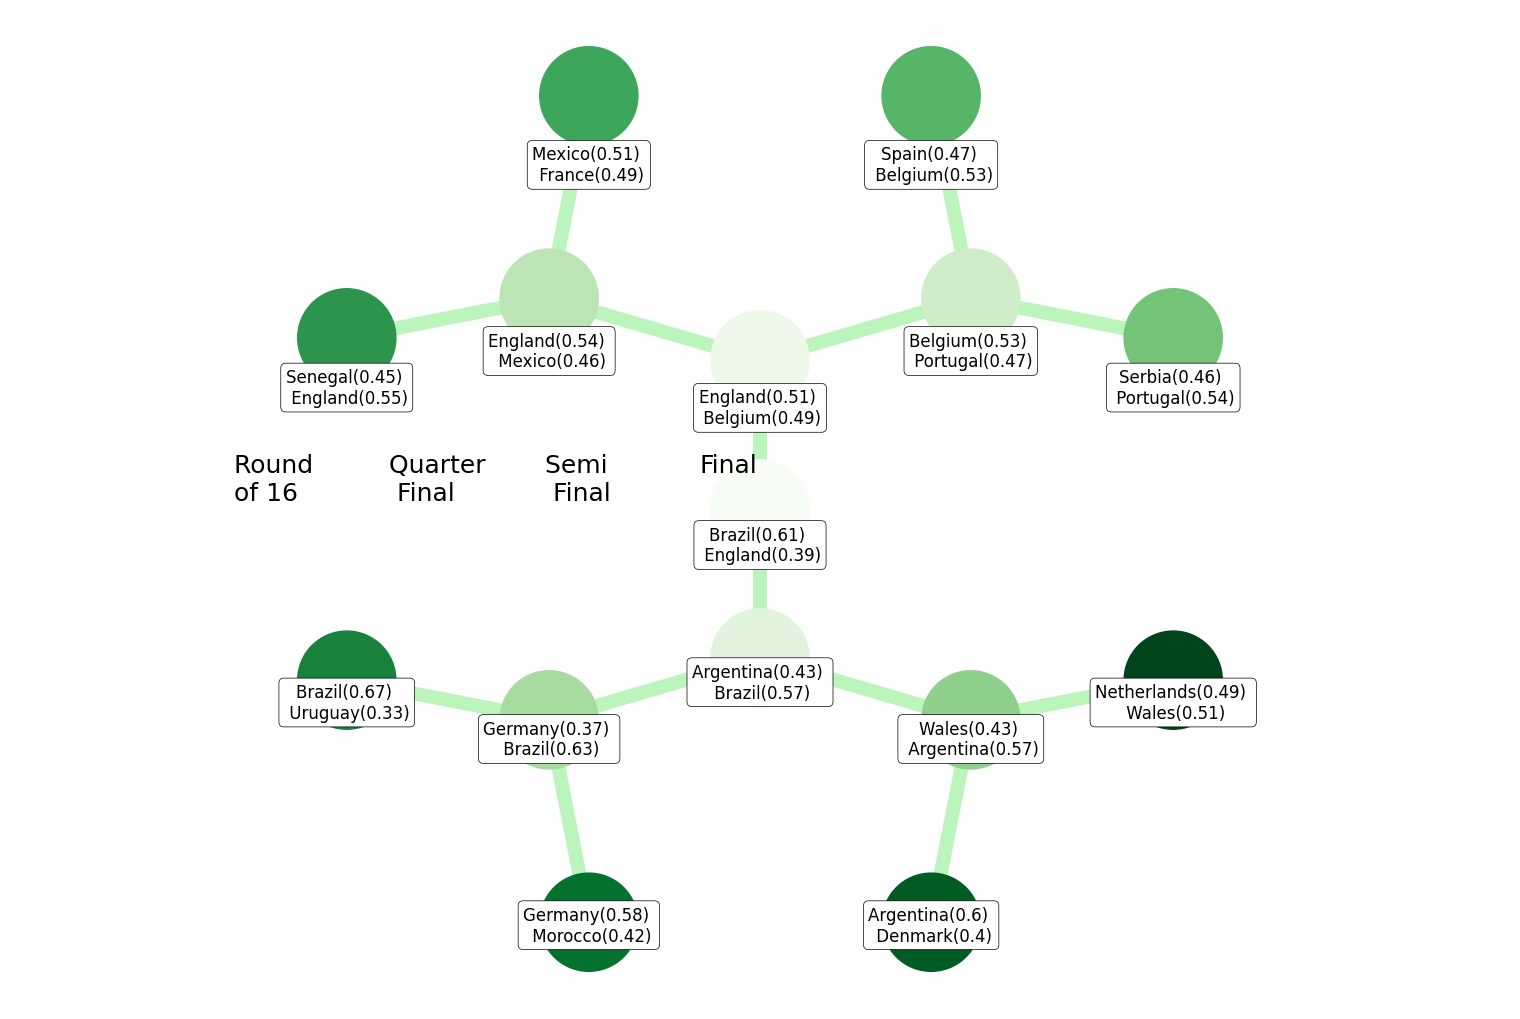

In [51]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

Em todas as 3 simulações com modelos difentes o Brasil consegue o Hexa! 

Com alguns pequenos upsets (favorito sendo derrotado).